# IDS Bayesian Interferometry

In [1]:
from pymc3 import *
import numpy as np

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
def show_fft_image(img_fft, shift = True):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    plt.show()

## Creating artificial data

In [3]:
size = 1
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 50
IMAGE_SIZE_Y = 50
SIGMA = 20

I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
Cx = np.clip(Cx,0,IMAGE_SIZE_X)
Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
Cy = np.clip(Cy,0,IMAGE_SIZE_Y)

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print('min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI]))

min I: 248.0 at (24,8)
max I: 248.0 at (24,8)



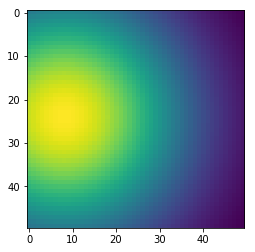

In [4]:
import matplotlib.pyplot as plt
from modelfunctions import *

Im_sinthc = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
plt.imshow(Im_sinthc)
plt.show()

img = Im_sinthc #rename variable

In [5]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

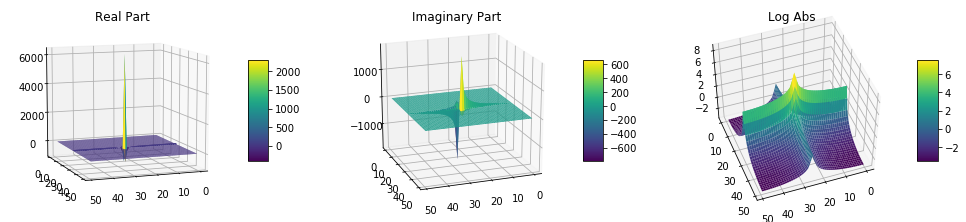

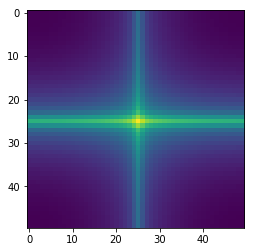

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 3D plotting
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 3, 1, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.real)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Real Part")

ax.view_init(elev=10., azim = 70)

# 3D plotting
ax = fig.add_subplot(1, 3, 2, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.imag)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Imaginary Part")

ax.view_init(elev=20., azim = 70)

# 3D plotting
ax = fig.add_subplot(1, 3, 3, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(np.log(img_fftabs+0.001))


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Log Abs")

ax.view_init(elev=50., azim = 70)

fig.set_figheight(3.7)
fig.set_figwidth(17)

plt.show(fig)

show_fft_image(np.log(img_fftabs+1e-12))

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

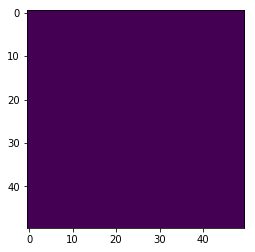

In [7]:
from masking import *

## Parameters
B_max = 1
antennas = 24
typeArray = 'ALL'
sigma = B_max/6

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

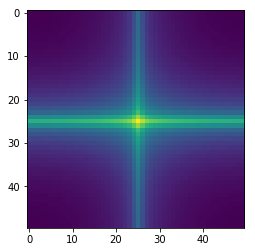

In [8]:
measurements,U,V = UVCreator(np.fft.fftshift(img_fft),mask)

measurements_abs = np.log(np.abs(measurements)+0.01)
show_fft_image(measurements_abs, shift=False)


## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$


$$
\phi_i(u,v) = 2 \pi \sigma^2 \exp \left(-2 \pi\left(j C_x^i u+jC_y^i v+\pi  \sigma^2\left(u^2+v^2\right)\right)\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 u-C_x^i \right),e^{-2 \pi^2 \sigma^2}\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 v-C_y^i\right),e^{-2 \pi^2 \sigma^2}\right)
$$


where:

$$
\vartheta_3 (q,z) = 1 + 2\sum_{n = 1}^{\infty} q^{n^2}\cos(2nz)
$$

In [9]:
def myshift(x,size, axes = None):
    # x: image's positions
    #    type: numpy array
    #    Shape: (numberOfSamplings, 2)
    # size: (IMAGE_SIZE_X, IMAGE_SIZE_Y)
    #       type: numpy array
    
    y = np.zeros(x.shape)
    
    xPos = np.ceil(size[0]/2).astype(int)
    xNeg = (size[0] - xPos).astype(int)
    yPos = np.ceil(size[1]/2).astype(int)
    yNeg = (size[1] - yPos).astype(int)
    
    #print("Centers: %s,%s" % (xPos, yPos))
    
    for i in range(x.shape[0]):
        if x[i,0] >= xNeg:
            y[i,0] = x[i,0]-xNeg
        else:
            y[i,0] = x[i,0]+xPos
            
        if x[i,1] >= yNeg:
            y[i,1] = x[i,1] - yNeg
        else:
            y[i,1] = x[i,1] + yPos
    
    return y.astype(x.dtype)

def shiftMatrix(A,positions):
    k = 0
    B = np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            B[i,j] = A[positions[k,0],positions[k,1]]
            k += 1
            #print(B)
    return B.astype(A.dtype)

A = np.array([[1,2,3,4,5,6,7],[8,9,10,11,12,13,14],[15,16,17,18,19,20,21]])
# A = np.array([[1,2],[3,4]])
# A = np.arange(1000).reshape(10, 100)
print("Original:")
print(A)
x_list = []

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        x_list.append([i,j])
x = np.array(x_list)
#print(x)
size = A.shape
positions = myshift(x,size)
#print(positions)
print('My Shift:')
A_myshifted = shiftMatrix(A,positions)
print(A_myshifted)
print("FFT shift:")
A_fftshifted = np.fft.fftshift(A)
print(A_fftshifted)
print("Validation: %s" % ( np.array_equal(A_myshifted, A_fftshifted)) )

Original:
[[ 1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14]
 [15 16 17 18 19 20 21]]
My Shift:
[[19 20 21 15 16 17 18]
 [ 5  6  7  1  2  3  4]
 [12 13 14  8  9 10 11]]
FFT shift:
[[19 20 21 15 16 17 18]
 [ 5  6  7  1  2  3  4]
 [12 13 14  8  9 10 11]]
Validation: True


In [10]:
import theano.tensor as tt

PI = np.pi
def Vobs_function(U,l,alpha,Cx,Cy, IMAGE_SIZE_X = 50, IMAGE_SIZE_Y = 50, shift = True):
#     print "U shape: %s, U type: %s\nl type: %s\nCx and Cy type: %s"%(U.shape, type(U), type(l), type(Cx))
#     U_tmp = U
#     C_tmp = tt.stack([Cx,Cy], axis = 1)
#     if shift:
#         U_tmp = U_tmp - np.array([IMAGE_SIZE_X, IMAGE_SIZE_Y])/2
#         C_tmp = C_tmp - np.array([IMAGE_SIZE_X, IMAGE_SIZE_Y])/2
    
    u = U[:,0] - IMAGE_SIZE_X/2  
    u_aux = u[:,np.newaxis]
    v = U[:,1] - IMAGE_SIZE_Y/2
    v_aux = v[:,np.newaxis]
    
    Cx_aux = Cx - IMAGE_SIZE_X/2
    Cy_aux = Cy - IMAGE_SIZE_Y/2
    
    A = tt.exp(-2.0*PI*PI*(u_aux * u_aux + v_aux * v_aux) *l*l)
#     A_aux = tt.extra_ops.repeat(A, numberOfBasis,axis=1)
#     print 'Atenuation:'
#     print A.eval()
#     print 'max: %s, min: %s' % ( np.max(A.eval()), np.min(A.eval() ))
    
#     print "Amplitude shape: %s, Amplitude type: %s" %(A_aux.eval().shape, type(A))
#     argument = 2.0 * PI * (np.outer(u,Cx) + np.outer(v,Cy))
    argument = -2.0*PI*(u[:,None]*Cx_aux[None,:] + v[:,None]*Cy_aux[None,:])
#     print "argument shape: %s, argument type: %s" %(argument.shape, type(argument))
    
    cosPart = tt.cos(argument)
    sinPart = tt.sin(argument)
    
#     print "Cosine:"
#     print cosPart.eval()
#     print "Sine:"
#     print sinPart.eval()
    
#     print "cosPart shape: %s, cosPart type: %s" %(cosPart.eval().shape, type(cosPart))

    RePart = tt.mul(A,cosPart)
    ImPart = tt.mul(A,sinPart)
    
#     print "RePart shape: %s, RePart type: %s" %(RePart.eval().shape, type(cosPart))
    
    alpha_aux = alpha
#     print "alpha shape: %s, alpha type: %s" %(alpha.shape, type(alpha))
    
    return tt.sum(tt.mul(alpha_aux,RePart), axis = 1), tt.sum(tt.mul(alpha_aux,ImPart), axis = 1)

In [11]:
numberOfSamplings = U.shape[0]
numberOfBasis = size

l = 0.01
init_alpha = np.array([1,1])
init_Cx = np.array([1,1])
init_Cy = np.array([0,0])
init_U = np.array([[0,1],[1,0], [1,1]])

PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_Cx,init_Cy, shift = False)
print('Toy Example:')
print(np.array([PHI_Re.eval(),PHI_Im.eval()]).T)

Toy Example:
[[  1.86834553e-01   7.61541505e-14]
 [  1.86834553e-01   1.22663789e-13]
 [  2.05808393e-01  -2.26115517e-14]]


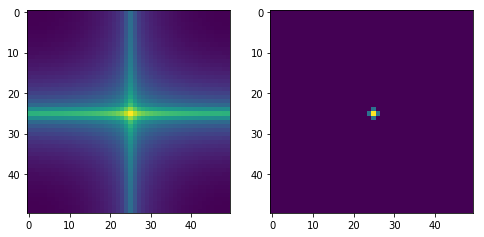

In [12]:
numberOfSamplings = U.shape[0]
numberOfBasis = size

l = SIGMA*0.05
init_alpha = I*l*np.sqrt(2*PI)
init_Cx = Cx
init_Cy = Cy
init_U = U.astype(int)

PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_Cx,init_Cy, IMAGE_SIZE_X = 50, IMAGE_SIZE_Y = 50, shift=True)

def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = 50, IMAGE_SIZE_Y = 50):
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag


Im_real, Im_imag = matrix_points(U,V[:,0], V[:,1])
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(8)

ax[0].imshow( np.log(np.sqrt(Im_real*Im_real+Im_imag*Im_imag) ) )

Im_real, Im_imag = matrix_points(U,PHI_Re.eval(), PHI_Im.eval())
ax[1].imshow( np.log(np.sqrt(Im_real*Im_real+Im_imag*Im_imag) +0.00000000001) )
plt.show(fig)

In [13]:
#from scipy import optimize

numberOfSamplings = U.shape[0]
numberOfBasis = size
rbf_model = Model()

l = SIGMA
init_alpha = I*l*np.sqrt(2*PI)
init_Cx = Cx
init_Cy = Cy
init_sigma = np.abs(10*np.random.randn(2,2))

with rbf_model:
    alpha_model = Normal('alpha', mu=init_alpha, sd=5, shape = numberOfBasis)
    Cx_model = Normal('Cx', mu=init_Cx, sd=5, shape = numberOfBasis)
    Cy_model = Normal('Cy', mu=init_Cy, sd=5, shape = numberOfBasis)
    l_model = Lognormal('l', mu = l, sd=5, shape = 1)
    sigma_model = Lognormal('sigma', init_sigma, np.ones(2), shape=(2,2), testval=init_sigma)

    PHI_Re, PHI_Im = Vobs_function(U, l_model, alpha_model, Cx_model, Cy_model)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)
    
    V_obs = MvNormal('V_obs', mu=V_model, cov=sigma_model, observed=V)
    
    n_samples = 1000
    
#     step = Metropolis()
#     sample(n_samples, step)
estimation = find_MAP(model = rbf_model)
print(estimation)

ValueError: ('You cannot drop a non-broadcastable dimension.', ((False, False), ('x', 0)))

In [ ]:
print( (init_alpha - estimation['alpha'])/init_alpha )
print( (Cx - estimation['Cx'])/Cx )
print( (Cy - estimation['Cy'])/Cy )
print( "%s %s" % (l,estimation['l_log_']))

# l